# Initialisation de l'environnement

## GPU alloué

Vérifier via la commande `nvidia-smi`, que la carte graphique allouée est une : Tesla T4, P4, ou P100.


In [ ]:
!nvidia-smi

Wed Mar 10 11:38:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Version de Ubuntu

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


## Version du driver Cuda

In [ ]:
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
/usr/local/cuda/bin/nvcc


## Installations recommandées par Nvidia

https://rapids.ai/start.html

En fonction de la version d'Ubuntu et de Python, la version du compilateur gcc ainsi que le driver Cuda, doivent être dans des versions compatibles

## Setup

1. Intallation de Miniconda (4.5.4) avec Python 3.7 (compatible et supporté par Google colab)
1. Installation des librairies RAPIDS 0.18 :
  1. cuPY (numpy)
  1. cuDF (Pandas)
  1. cuML (scikit-learn)
  1. cuDNN (interface pour le Deep Learning)
  1. xgboost and dask-xgboost
1. Initialisation des variables d'environnement
1. Copie des fichiers .so RAPIDS de /usr/local/lib vers /usr/lib/

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

## Conda commandes

https://docs.conda.io/projects/conda/en/latest/commands/install.html#Positional%20Arguments  

In [ ]:
!conda env list

# conda environments:
#
base                  *  /usr/local



In [ ]:
!conda list | grep cu

arrow-cpp                 1.0.1           py37h9631afc_16_cuda    conda-forge
arrow-cpp-proc            3.0.0                      cuda    conda-forge
cudatoolkit               11.0.221             h6bb024c_0    nvidia
cudf                      0.18.0          cuda_11.0_py37_g20778e5ddb_0    rapidsai/label/main
cudf_kafka                0.18.0          py37_g20778e5ddb_0    rapidsai/label/main
cudnn                     8.0.0                cuda11.0_0    nvidia
cugraph                   0.18.0          py37_g65ec965f_0    rapidsai/label/main
cuml                      0.18.0          cuda11.0_py37_gb5f59e005_0    rapidsai/label/main
cupy                      8.0.0            py37h0ce7dbb_0    rapidsai/label/main
curl                      7.71.1               he644dc0_3    conda-forge
cusignal                  0.18.0          py38_g42899d2_0    rapidsai/label/main
cuspatial                 0.18.0          py37_gf4da460_0    rapidsai/label/main
custreamz                 0.18.0          py3

## Kmeans CPU vs GPU

### cuDF

**Import des variables**

In [ ]:
import cudf; print('cuDF Version:', cudf.__version__)
import cuml; print('cuML Version:', cuml.__version__)
import cupy; print('cuPY Version:', cupy.__version__)
import pandas as pd; print('Pandas Version:', pd.__version__)
import numpy as np
import matplotlib.pyplot as plt

cuDF Version: 0.18.0
cuML Version: 0.18.0
cuPY Version: 8.0.0
Pandas Version: 1.1.5


**Création du jeu de données**

Sur mémoire CPU : pandas dataframe

In [ ]:
from sklearn.datasets import make_blobs

X_blob, y_blob = make_blobs(n_samples=int(1e3), n_features=2, centers=3, cluster_std=0.6, random_state=0)

In [ ]:
df = pd.DataFrame(X_blob, columns=["x", "y"])

**Copie du jeu de données sur mémoire GPU**

In [ ]:
gdf = cudf.DataFrame.from_pandas(df)

In [ ]:
gdf.head(5)

,x,y
0,-1.095103,2.768831
1,1.546323,4.212973
2,-1.510861,3.027952
3,-1.276192,2.893871
4,-2.129498,2.318967


## Sklearn - CPU

Entrainement du modèle avec scikit-learn sur CPU

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
%%time

kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=20, random_state=1).fit_predict(df)

CPU times: user 44.1 ms, sys: 1.17 ms, total: 45.3 ms
Wall time: 30.7 ms


## cuML - GPU

Entrainement du modèle avec RAPIDS / cuML, sur GPU

In [ ]:
import cuml

In [ ]:
%%time

kmeans_g = cuml.KMeans(n_clusters=3, init="k-means++", max_iter=20, random_state=1).fit_predict(gdf)

CPU times: user 5.34 ms, sys: 2.11 ms, total: 7.45 ms
Wall time: 8.23 ms


In [ ]:
gdf_lbl = np.insert(df.to_numpy(), 2, kmeans_g.to_array(), axis=1)

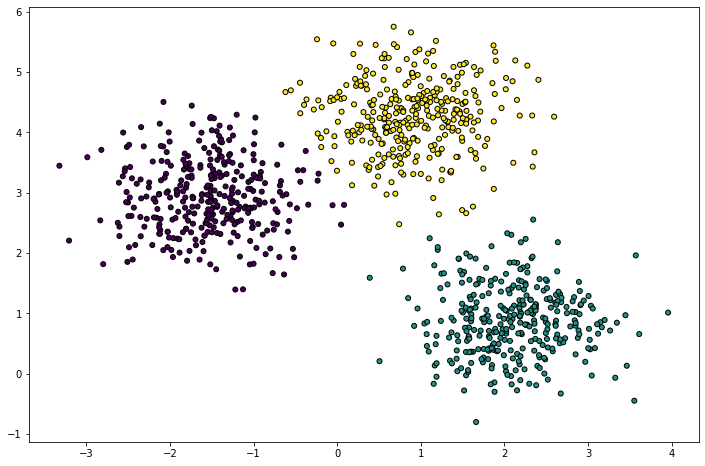

In [ ]:
plt.figure(figsize=(12, 8))

plt.scatter(gdf_lbl[:, 0], gdf_lbl[:, 1], marker='o', c=gdf_lbl[:, 2], s=25, edgecolor='k')

## Sklearn - CPU : Déterminer le bon nombre de clusters

### 1. Courbe de Elbow - Inertie intra cluster

### 2. Silhouette score

In [ ]:
# plot silhouette score matrix to evaluate kmeans
from sklearn.metrics import silhouette_score
import seaborn as sns 

In [ ]:
clusters_range = range(2,6)
random_seed = range(0,5)
inertia = []
results = []

for c in clusters_range:
    inertia_by_seed = []
    for r in random_seed:
        # train kmeans
        kmeans_mod = KMeans(n_clusters=c, random_state=r).fit(df)
        # get intra cluster inertia 
        inertia_by_seed.append(kmeans_mod.inertia_)

        # get labellisation / group for each point
        labels = kmeans_mod.predict(df)
        # scoring for each cluster [-1 ; 1]
        score_cluster = silhouette_score(df, labels, metric='euclidean')
        results.append([c, r, score_cluster])

    inertia.append(inertia_by_seed) 

# dataframe list format
sil_sco_df = pd.DataFrame(results, columns=["nb_clusters", "seed", "silhouette_score"])
# create table of 2 dimensions
sil_sco_tbl = pd.pivot_table(sil_sco_df, index="nb_clusters", columns="seed", values="silhouette_score")

### 1. Courbe de Elbow

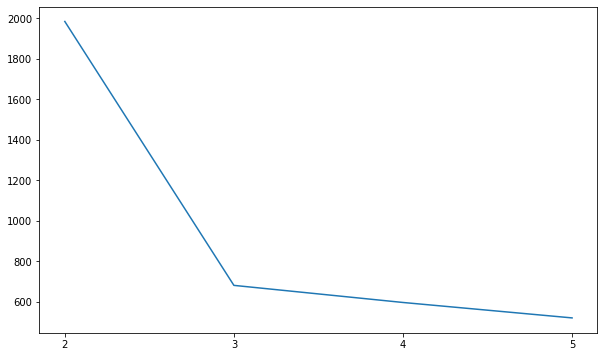

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.xticks(clusters_range)

a = plt.errorbar(np.array(clusters_range), [np.mean(m) for m in inertia], [np.std(m) for m in inertia])

### 2. Silhouette score

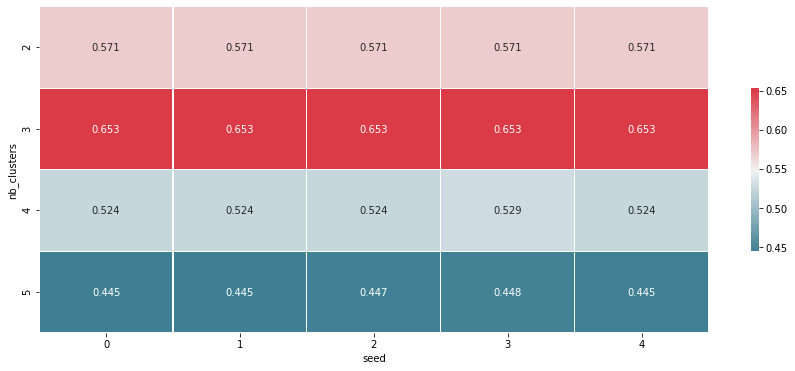

In [ ]:
fig = plt.figure(figsize=(15,6))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(sil_sco_tbl, cmap=cmap, linewidths=.1, cbar_kws={"shrink": 0.5}, annot=True, annot_kws={"size": 10}, fmt='.3f')

plt.show() 

# KMeans sur dataset réel

Lien du dataset : https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Read dataset in GPU memory directly

In [ ]:
retail_gdf = cudf.read_csv("/content/drive/MyDrive/Colab Notebooks/Cours BD/Séance 3 - GPU - Rapids/online_retail.csv", sep=';', decimal='.', )

In [ ]:
retail_gdf.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


In [ ]:
retail_gdf.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
CustomerID     float64
Country         object
dtype: object

### Label encoder

Transform alphanumeric values to numeric

In [ ]:
%%time

le = cuml.preprocessing.LabelEncoder()
retail_gdf["Country"] = le.fit_transform(retail_gdf["Country"])

CPU times: user 50.2 ms, sys: 37 ms, total: 87.2 ms
Wall time: 90.6 ms


In [ ]:
%%time

retail_gdf["StockCode"] = le.fit_transform(retail_gdf["StockCode"])

### Count the different number of products and customers

In [ ]:
retail_gdf["StockCode"].nunique()

5305

In [ ]:
retail_gdf["CustomerID"].nunique()

5942

### Remove non integer columns form kmeans

In [ ]:
retail_gdf_c = retail_gdf.drop(["Invoice", "Description", "InvoiceDate"], axis=1)
retail_gdf_c.head(5)

,StockCode,Quantity,Price,CustomerID,Country
0,4551,12,6.95,13085.0,40
1,3701,12,6.75,13085.0,40
2,3703,12,6.75,13085.0,40
3,1396,48,2.10,13085.0,40
4,711,24,1.25,13085.0,40


### Replace null values

In [ ]:
retail_gdf_c["CustomerID"].isna().sum() / retail_gdf_c["CustomerID"].count()

0.29478118889228544

In [ ]:
retail_gdf_c["CustomerID"] = retail_gdf_c["CustomerID"].fillna(0)

## Train Kmeans

In [ ]:
%%time

clusters_range = range(2,7)
random_seed = range(0,5)
inertia = []

for c in clusters_range:
    inertia_by_seed = []
    for r in random_seed:
        # train kmeans
        kmeans_mod = cuml.KMeans(n_clusters=c, init="k-means++", random_state=r).fit(retail_gdf_c)
        # get intra cluster inertia 
        inertia_by_seed.append(kmeans_mod.inertia_)

        # get labellisation / group for each point
        labels = kmeans_mod.predict(retail_gdf_c)

    inertia.append(inertia_by_seed) 

CPU times: user 5.67 s, sys: 5.61 s, total: 11.3 s
Wall time: 11.3 s


### Display Elbow curve

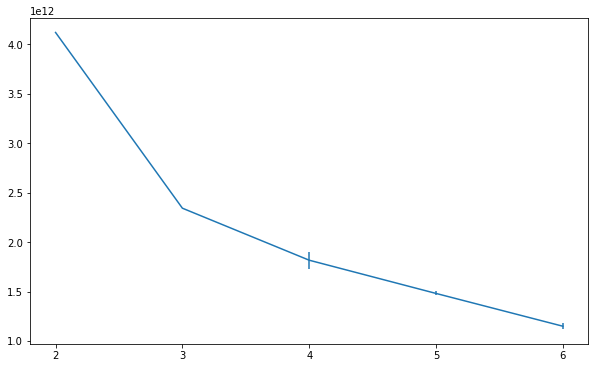

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.xticks(clusters_range)

a = plt.errorbar(np.array(clusters_range), [np.mean(m) for m in inertia], [np.std(m) for m in inertia])

### Train Kmeans with optimal cluster number

In [ ]:
labels = cuml.KMeans(n_clusters=4, init="k-means++", random_state=r).fit_predict(retail_gdf_c)

In [ ]:
retail_gdf_c['Cluster'] = labels.astype(object)

In [ ]:
retail_gdf_c.head(5)

,StockCode,Quantity,Price,CustomerID,Country,Cluster
0,4551,12,6.95,13085.0,40,0
1,3701,12,6.75,13085.0,40,0
2,3703,12,6.75,13085.0,40,0
3,1396,48,2.10,13085.0,40,0
4,711,24,1.25,13085.0,40,0


### Made investigations inside clusters

**Cluster size**

In [ ]:
retail_gdf_c.groupby('Cluster')["CustomerID"].count()

Cluster
1     66208
0    431212
3    176799
2    393152
Name: CustomerID, dtype: int32

**Quantity and mean price by cluster**

In [ ]:
retail_gdf_c.groupby('Cluster')[["Quantity", "Price"]].mean()

,Quantity,Price
Cluster,,
1,0.785615,16.936132
0,13.556538,3.890022
3,1.823257,4.583131
2,11.162059,3.442936


In [ ]:
retail_df = retail_gdf_c.to_pandas()

In [ ]:
retail_df = retail_df[retail_df['Quantity'].between(0, 100)]
retail_df = retail_df[retail_df['Price'].between(0, 100)]

In [ ]:
import plotly.express as px

fig = px.scatter(retail_df, x='Quantity', y='Price', color="Cluster")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

**Number of products by cluster**

In [ ]:
retail_gdf_c.groupby('Cluster')[["StockCode"]].nunique()

,StockCode
Cluster,
0,4530
1,2474
2,4528
3,2703


**Number of country by cluster**

In [ ]:
retail_gdf_c["Country"].nunique()

43

In [ ]:
retail_gdf_c.groupby('Cluster')[["Country"]].nunique()

,Country
Cluster,
0,38
1,15
2,14
3,15
